<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
!pip install torch-optimizer

In [ ]:
import os
#import torch_optimizer as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tommykamaz/faces-dataset-small

mkdir: cannot create directory ‘/root/.kaggle’: File exists
faces-dataset-small.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir images
!unzip -q -o faces-dataset-small.zip -d images | awk 'BEGIN {ORS=" "} {if(NR%50==0)print "."}'

mkdir: cannot create directory ‘images’: File exists


In [ ]:
DATA_DIR = './images/'

In [ ]:
def get_dataloader(image_size, batch_size):
  train_ds = ImageFolder(DATA_DIR, transform = tt.Compose([
      tt.Resize(image_size),
      tt.CenterCrop(image_size),
      tt.ToTensor(),
      #tt.Normalize(*stats)
  ]))
  train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 2)
  return train_dl

  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """
  # TODO: resize images, convert them to tensors and build dataloader
  #pass

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
image_size = 128
batch_size = 16
#stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
train_dl = get_dataloader(image_size, batch_size)
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    #in: 3 x 128 x 128
    nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size = 4),   #out: 32 x 32 x 32
 #   nn.MaxPool2d(kernel_size=  2), #out: 32 x 64 x 64

 #   nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
 #   nn.ReLU(),
 #   nn.BatchNorm2d(64),
 #   nn.MaxPool2d(kernel_size = 2), #out: 64 x 32 x 32



    nn.Conv2d(in_channels = 32, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size = 2), #out: 128 x 16 x 16

    nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(kernel_size = 2), #out: 256 x 8 x 8

    nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.MaxPool2d(kernel_size = 2), #out: 512 x 4 x 4

    nn.Conv2d(in_channels = 512, out_channels = 1, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(1),
    nn.MaxPool2d(kernel_size = 4), #out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()

)

In [ ]:
latent_size = 128  # choose latent size
'''
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
)
'''
generator = nn.Sequential(
    #in: latent size x 1 x 1

    nn.ConvTranspose2d(in_channels = latent_size, out_channels = 256, kernel_size = 2, stride = 2, padding = 0),
    nn.ReLU(),
    nn.BatchNorm2d(256),  #out: 256 x 2 x 2

    nn.ConvTranspose2d(in_channels = 256, out_channels = 512, kernel_size = 2, padding = 0, stride = 2),
    nn.ReLU(),
    nn.BatchNorm2d(512),  #out: 512 x 4 x 4

    nn.ConvTranspose2d(in_channels = 512, out_channels = 666, kernel_size = 3, padding = 1, stride = 2, output_padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(666),  #out: 666 x 8 x 8

    nn.ConvTranspose2d(in_channels = 666, out_channels = 512, kernel_size = 3, padding = 1, stride = 2, output_padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(512),  #out: 512 x 16 x 16

    nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1, stride = 2, output_padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(512),  #out: 512 x 32 x 32

    nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1, stride = 2, output_padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d(256),  #out: 256 x 64 x 64

    nn.ConvTranspose2d(in_channels = 256, out_channels = 3, kernel_size = 3, padding = 1, stride = 2, output_padding = 1),
    nn.Tanh(),
    #out: 3 x 128 x 128


)


# Как на занятии

In [ ]:
discriminator_ = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    #nn.LeakyReLU(0.2, inplace=True),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    #nn.LeakyReLU(0.2, inplace=True),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    #nn.LeakyReLU(0.2, inplace=True),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    #nn.LeakyReLU(0.2, inplace=True),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    #nn.LeakyReLU(0.2, inplace = True),
    nn.ReLU(True),
    # out: 256 x 4 x 4

    nn.Conv2d(256, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),


    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
latent_size = 128
generator_ = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    #out: 32 x 64 x 64
    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
torch.cuda.empty_cache()

In [ ]:
lr_d = 1e-4
lr_g = 1e-3

model = {
    "discriminator": discriminator_.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach().cpu()[:nmax], nrow=8).permute(1, 2, 0))

In [ ]:
def show_batch(dl):
  for images, _ in dl:
    show_images(images)
    break

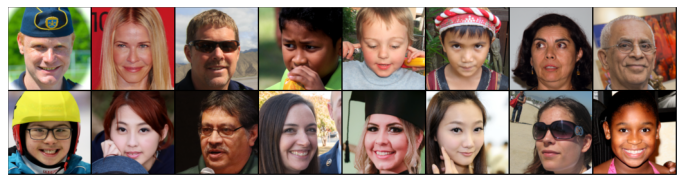

In [ ]:
show_batch(train_dl)

torch.Size([16, 3, 128, 128])


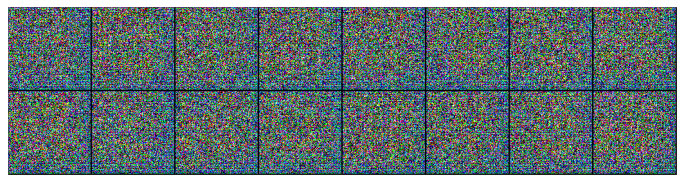

In [ ]:
rand_noise = torch.randn(batch_size, latent_size, 1, 1)
fake_imgs = model["generator"](rand_noise.to(device))
print(fake_imgs.shape)
show_images(fake_imgs)


In [ ]:
def fit(model, criterion, epochs, lr_d, lr_g):

  optimizer = {
      "discriminator": torch.optim.Adam(model["discriminator"].parameters(), lr = lr_d,
                                        betas = (0.5, 0.999)),
      #"generator": torch.optim.Adadelta(model['generator'].parameters(), lr = 2.0)
      #"generator": optim.AdaBound(model["generator"].parameters(), lr = 1e-3,
      #                            betas = (0.5, 0.999))
      "generator": torch.optim.Adam(model["generator"].parameters(), lr = lr_g,
                                    betas = (0.5, 0.999))
  }

  model['discriminator'].train()
  model['generator'].train()

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  for epoch in range(epochs):
    d_loss_per_epoch = []
    g_loss_per_epoch = []
    real_score_per_epoch = []
    fake_score_per_epoch = []

    for real_images, _ in tqdm(train_dl):

      optimizer['discriminator'].zero_grad()
      real_preds = model['discriminator'](real_images)
      real_targets = torch.ones(real_images.size(0), 1, device = device)
      real_loss = criterion['discriminator'](real_preds, real_targets)

      cur_real_score = torch.mean(real_preds).item()

      rand_noise = torch.randn(batch_size, latent_size, 1, 1, device = device)
      fake_images = model['generator'](rand_noise)
      fake_preds = model['discriminator'](fake_images)
      fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
      fake_loss = criterion['discriminator'](fake_preds, fake_targets)

      cur_fake_score = torch.mean(fake_preds).item()

      real_score_per_epoch.append(cur_real_score)
      fake_score_per_epoch.append(cur_fake_score)

      d_loss = real_loss + fake_loss
      d_loss.backward()
      optimizer['discriminator'].step()
      d_loss_per_epoch.append(d_loss.item())

      optimizer['generator'].zero_grad()

      latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
      images = model['generator'](rand_noise)
      preds = model['discriminator'](images)
      targets = torch.ones(batch_size, 1, device = device)
      g_loss = criterion['generator'](preds, targets)
      g_loss.backward()
      optimizer['generator'].step()

      g_loss_per_epoch.append(g_loss.item())

    losses_g.append(np.mean(g_loss_per_epoch))
    losses_d.append(np.mean(d_loss_per_epoch))
    real_scores.append(np.mean(real_score_per_epoch))
    fake_scores.append(np.mean(fake_score_per_epoch))

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
  return losses_g, losses_d, real_scores, fake_scores


  # TODO: build optimizers and train your GAN
  # pass

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
epochs = 40

In [ ]:
history = fit(model, criterion, epochs, lr_d, lr_g)

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 6.7222, loss_d: 0.1672, real_score: 0.9619, fake_score: 0.0513


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 2.5254, loss_d: 1.0365, real_score: 0.6486, fake_score: 0.3497


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 1.3935, loss_d: 1.2605, real_score: 0.5581, fake_score: 0.4380


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 1.3697, loss_d: 1.3257, real_score: 0.5401, fake_score: 0.4597


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 1.5092, loss_d: 1.2637, real_score: 0.5539, fake_score: 0.4426


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 1.5759, loss_d: 1.2386, real_score: 0.5636, fake_score: 0.4340


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 1.8253, loss_d: 1.1938, real_score: 0.5782, fake_score: 0.4196


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 1.6835, loss_d: 1.2269, real_score: 0.5654, fake_score: 0.4327


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 1.8894, loss_d: 1.1688, real_score: 0.5862, fake_score: 0.4128


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 2.0330, loss_d: 1.1176, real_score: 0.6008, fake_score: 0.3944


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 2.1270, loss_d: 1.0833, real_score: 0.6153, fake_score: 0.3836


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 2.4127, loss_d: 0.9890, real_score: 0.6473, fake_score: 0.3530


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 2.5349, loss_d: 0.9498, real_score: 0.6593, fake_score: 0.3375


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 2.3944, loss_d: 0.9365, real_score: 0.6650, fake_score: 0.3320


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 2.4224, loss_d: 0.9763, real_score: 0.6568, fake_score: 0.3400


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 2.4284, loss_d: 0.9257, real_score: 0.6687, fake_score: 0.3301


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 2.5573, loss_d: 0.8613, real_score: 0.6888, fake_score: 0.3092


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 2.8678, loss_d: 0.7922, real_score: 0.7160, fake_score: 0.2837


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 2.8290, loss_d: 0.8121, real_score: 0.7092, fake_score: 0.2894


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 2.9244, loss_d: 0.7266, real_score: 0.7384, fake_score: 0.2589


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 3.1848, loss_d: 0.6470, real_score: 0.7641, fake_score: 0.2338


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 3.1876, loss_d: 0.6595, real_score: 0.7627, fake_score: 0.2375


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 3.3128, loss_d: 0.6140, real_score: 0.7759, fake_score: 0.2207


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 3.3082, loss_d: 0.5925, real_score: 0.7824, fake_score: 0.2160


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 3.4715, loss_d: 0.5979, real_score: 0.7863, fake_score: 0.2130


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 3.6607, loss_d: 0.5051, real_score: 0.8145, fake_score: 0.1842


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 3.7901, loss_d: 0.4798, real_score: 0.8233, fake_score: 0.1743


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 3.7965, loss_d: 0.4572, real_score: 0.8315, fake_score: 0.1686


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 3.9450, loss_d: 0.4592, real_score: 0.8347, fake_score: 0.1641


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 4.0406, loss_d: 0.3931, real_score: 0.8523, fake_score: 0.1473


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 4.2498, loss_d: 0.3737, real_score: 0.8610, fake_score: 0.1376


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 4.3294, loss_d: 0.3330, real_score: 0.8750, fake_score: 0.1240


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 4.4781, loss_d: 0.3359, real_score: 0.8764, fake_score: 0.1236


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 4.5551, loss_d: 0.3237, real_score: 0.8794, fake_score: 0.1202


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 4.5174, loss_d: 0.3011, real_score: 0.8852, fake_score: 0.1137


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 4.6222, loss_d: 0.3095, real_score: 0.8847, fake_score: 0.1141


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 4.7330, loss_d: 0.2997, real_score: 0.8909, fake_score: 0.1092


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 4.6781, loss_d: 0.2417, real_score: 0.9050, fake_score: 0.0934


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 4.9529, loss_d: 0.2931, real_score: 0.8992, fake_score: 0.1017


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 4.8659, loss_d: 0.2339, real_score: 0.9092, fake_score: 0.0901


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history


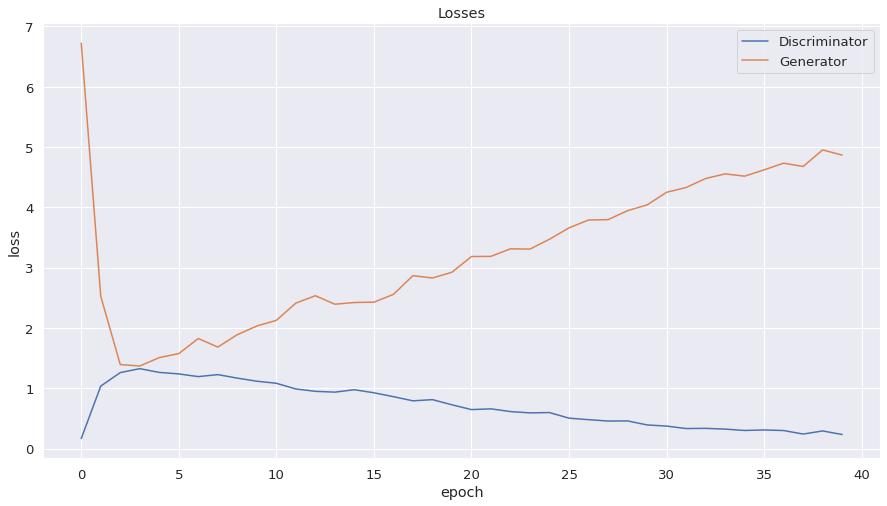

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Text(0.5, 1.0, 'Scores')

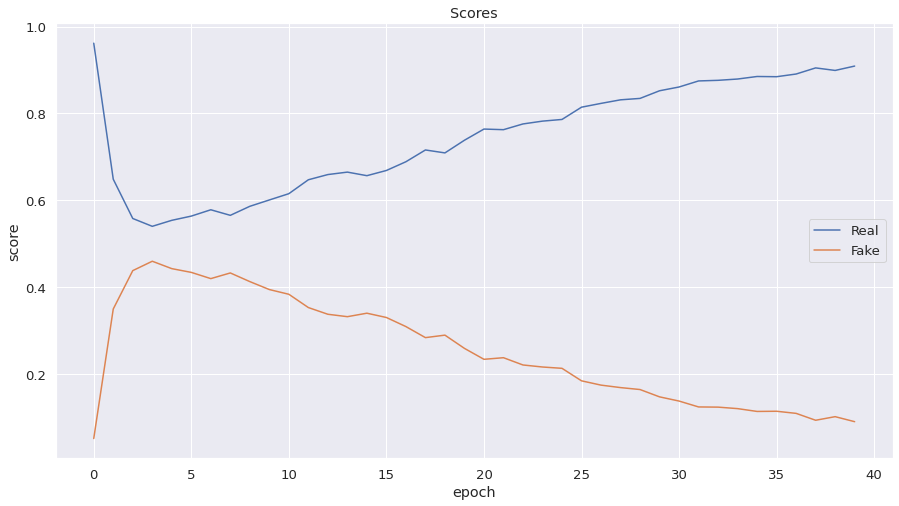

In [ ]:
plt.figure(figsize = (15, 8))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

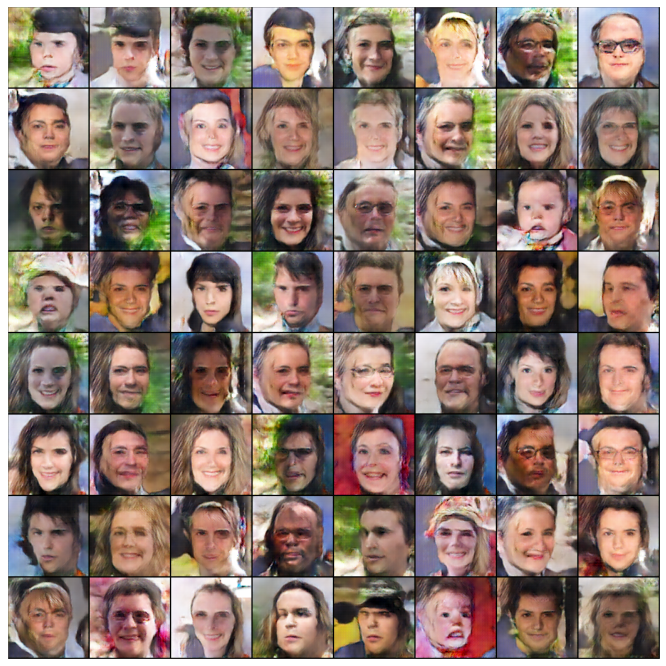

In [ ]:
n_images = 64
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)
show_images(fake_images)

Как вам качество получившихся изображений?

Что-то похожее на лица получается, но могло быть и лучше

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
torch.cuda.empty_cache()

In [ ]:
n_imgs = 3143
latent = torch.randn(n_imgs, latent_size, 1, 1, device = device)
generated_imgs = model['generator'](latent)
y_generated = np.zeros(n_imgs)
y_real = np.ones(n_imgs)
y = np.concatenate((y_generated, y_real))


OutOfMemoryError: ignored

In [ ]:
imgs, _ = next(iter(train_dl))
imgs.shape[0]

In [ ]:
model['generator'] = model['generator'].to('cpu')

In [ ]:
y_generated = torch.FloatTensor([]).to(device)
for imgs, _ in train_dl:
  torch.cuda.empty_cache()
  latent = torch.randn(imgs.shape[0], latent_size, 1, 1)#, device = device)
  generated = model['generator'](latent.to(device))
  y_generated = torch.cat((generated, y_generated))
y_generated = np.zeros(n_imgs)
y_real = np.ones(n_imgs)
y = np.concatenate((y_generated, y_real))

In [ ]:
#all_images = [real_imgs for real_imgs, _ in train_dl]
all_images = torch.FloatTensor([]).to(device)
for imgs, _ in train_dl:
  all_images = torch.cat((all_images, imgs))

#all_images = torch.cat()

In [ ]:
all_images.shape

In [ ]:
generated_imgs.shape

In [ ]:
X = torch.cat((generated_imgs, all_images)).detach().cpu().numpy()

In [ ]:
X.shape

In [ ]:
X = X.reshape((len(X), -1))

In [ ]:

from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
one_neighb = KNeighborsClassifier(n_neighbors = 1)
loo = LeaveOneOut()
accur = 0
for (train_idx, test_idx) in loo.split(X):
  #print('train_idx:', train_idx)
  #print('test_idx:', test_idx)
  one_neighb.fit(X[train_idx], y[train_idx])
  prediction = one_neighb.predict(X[test_idx])
  accur += prediction == y[test_idx]
accur /= n_imgs
print(accur)


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
len(X)

In [ ]:
X.shape

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components = 2, learning_rate = 'auto', init = "random", perplexity = 30).fit_transform(X)

In [ ]:
X_embedded.shape

Прокомментируйте получившийся результат:

In [ ]:
plt.figure(figsize = (15, 15))
plt.scatter(X_embedded[:3143, 0], X_embedded[:3143, 1], color = 'r')
plt.scatter(X_embedded[3143:, 0], X_embedded[3143:, 1], color = 'g')
plt.legend(['Genrated', 'Real'])
